# Setup

In [4]:
#%pip install einops transformers sae_lens sae_vis
import einops
import os
from utils_folder import dashboards
from transformers import AutoModel, AutoTokenizer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes, convert_connor_rob_sae_to_our_saelens_format, download_sae_from_hf
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import seaborn as sns
import torch as t
import plotly_express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy import stats
from torch.utils.data import Dataset
from sae_vis.model_fns import AutoEncoderConfig, AutoEncoder
from transformer_lens import utils as tl_utils
from transformer_lens.hook_points import (
    HookPoint,
)

from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
device = t.device("cuda" if t.cuda.is_available() else "cpu")
from transformer_lens import HookedSAE, HookedSAEConfig
from transformer_lens.utils import download_file_from_hf


from importlib import reload
from utils_folder.autoencoder import AutoEncoder
import matplotlib as mpl
cmap = mpl.colormaps["Spectral"]

from utils_folder import SAE_metrics
from utils_folder import vector_metrics
from utils_folder import misc_utils

import torch 
reload(SAE_metrics)
reload(vector_metrics)


<module 'utils_folder.vector_metrics' from '/home/ubuntu/brianna-chrisman/MATS-2024/utils_folder/vector_metrics.py'>

# Load SAE, Data, Model

In [6]:
auto_encoder_run = "concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78"
sae = AutoEncoder.load_from_hf(auto_encoder_run)
model = HookedTransformer.from_pretrained("gelu-2l").to(device)

# Load Pile data
data = load_dataset("NeelNanda/pile-10k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=32)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"][:20000]

dataset = misc_utils.TokenDataset(all_tokens)
del tokenized_data, data, all_tokens

{'act_name': 'blocks.1.attn.hook_z',
 'act_size': 512,
 'anthropic_resample_last': 25000,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'concat_heads': True,
 'dead_direction_cutoff': 1e-07,
 'device': 'cuda',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'head': 'cat',
 'l1_coeff': 2.0,
 'layer': 1,
 'lr': 0.001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'name': 'gelu-2l_1_16384_z',
 'num_resamples': 4,
 'num_tokens': 2000000000,
 're_init_every': 50000,
 'reinit': 'reinit',
 'resample_factor': 0.01,
 'save_state_dict_every': 50000,
 'seed': 49,
 'seq_len': 128,
 'site': 'z',
 'wandb_entity': 'ckkissane',
 'wandb_project_name': 'concat-z-gelu-21-l1-lr-sweep-3'}
Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda


# Features

In [22]:
# Get named parameters from HookedTransformer
W_O = model.get_parameter('blocks.1.attn.W_O')
W_O_concat = W_O.flatten(0,1)
W_dec = sae.W_dec

def InterferenceChanges(vectors, W_O):
    """
    Compute the cosine similarity between the vectors in W_dec and W_residual
    """
    vectors  = vectors / vectors.norm(dim=1, keepdim=True)
    vectors_new = vectors @ W_O
    vectors_new = vectors_new / vectors_new.norm(dim=1, keepdim=True)

    cosine_sims_pre_wo = (vectors @ vectors.T)
    cosine_sims_post_wo = (vectors_new @ vectors_new.T)
    return cosine_sims_pre_wo, cosine_sims_post_wo #.flatten().cpu().detach().numpy(), cosine_sims_post_wo.flatten().cpu().detach().numpy()

def Flatten(mat):
    return mat.flatten().cpu().detach().numpy()

In [23]:
# FOr each row, scramble the columns
def ScrambleColumns(mat):
    mat = mat.clone()
    for i in range(mat.shape[0]):
        mat[i] = mat[i][t.randperm(mat.shape[1])]
    return mat

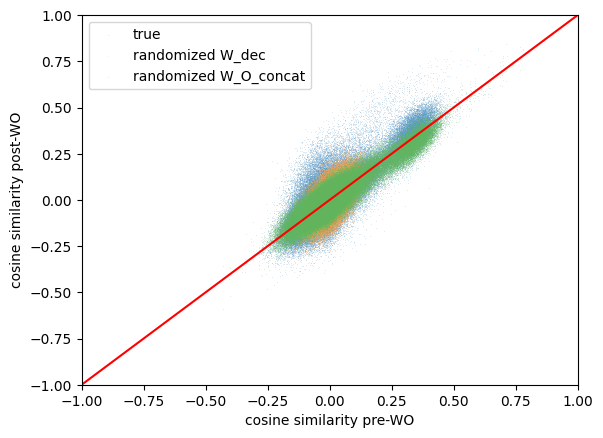

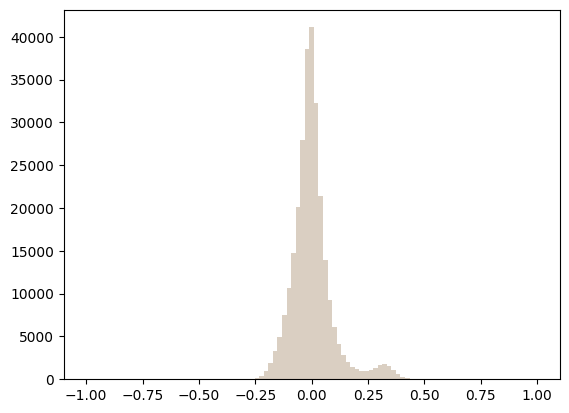

In [24]:
cosine_sims_pre_wo, cosine_sims_post_wo = InterferenceChanges(W_dec, W_O_concat)
sns.scatterplot(x=Flatten(cosine_sims_pre_wo)[::999],
                y=Flatten(cosine_sims_post_wo)[::999], s=.1, label='true')

cosine_sims_pre_wo_rand, cosine_sims_post_wo_rand = InterferenceChanges(
    ScrambleColumns(W_dec),
    W_O_concat)#[:,torch.randperm(W_O_concat.shape[1])])

sns.scatterplot(x=Flatten(cosine_sims_pre_wo_rand)[::999],
                y=Flatten(cosine_sims_post_wo_rand)[::999], s=.1, label='randomized W_dec')

cosine_sims_pre_wo_rand, cosine_sims_post_wo_rand = InterferenceChanges(
    W_dec,
    ScrambleColumns(W_O_concat))

sns.scatterplot(x=Flatten(cosine_sims_pre_wo_rand)[::999],
                y=Flatten(cosine_sims_post_wo_rand)[::999], s=.1, label='randomized W_O_concat')



plt.xlabel('cosine similarity pre-WO')
plt.ylabel('cosine similarity post-WO')
plt.plot([-1,1], [-1,1],'r-')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

plt.hist(Flatten(cosine_sims_pre_wo_rand[::999].to('cpu')), bins=np.linspace(-1,1,100), alpha=.2)
plt.hist(Flatten(cosine_sims_pre_wo[::999]), bins=np.linspace(-1,1,100), alpha=.2)
plt.show()

In [100]:
def ArgSort(tensor):

    flattened_tensor = tensor.flatten()

    # Step 2: Get the sorted indices of the flattened tensor
    sorted_indices_flattened = torch.argsort(flattened_tensor)

    # Step 3: Manually convert flattened indices back to 2D indices
    rows = sorted_indices_flattened // tensor.shape[1]
    cols = sorted_indices_flattened % tensor.shape[1]

    idxs = list(zip(rows.tolist(), cols.tolist()))

    return [(i,j) for i,j in idxs if i<j]


In [102]:
diffs = (cosine_sims_post_wo - cosine_sims_pre_wo)[:10, :10]


min_vals = ArgSort(diffs)[::-1][:5]
max_vals = ArgSort(diffs)[:5]

zero_vals = ArgSort(abs(diffs))[:5]

print('min diff')
for i in min_vals:
    print(i, cosine_sims_pre_wo[i].item(), cosine_sims_post_wo[i].item(), diffs[i].item()) 


print('max diff')
for i in max_vals:
    print(i, cosine_sims_pre_wo[i].item(), cosine_sims_post_wo[i].item(), diffs[i].item()) 


print('closest to zero diff')
for i in zero_vals:
    print(i, cosine_sims_pre_wo[i].item(), cosine_sims_post_wo[i].item(), diffs[i].item()) 




OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 21.99 GiB total capacity; 18.89 GiB already allocated; 533.75 MiB free; 20.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for in in 

# Let's look at the features where W_o creates less interference

In [50]:
cosine_sims_pre_wo, cosine_sims_post_wo = InterferenceChanges(W_dec, W_O_concat)
argmax_idx = argmax2d(cosine_sims_post_wo - cosine_sims_pre_wo)
print(cosine_sims_pre_wo[argmax_idx])
print(cosine_sims_post_wo[argmax_idx])
print(argmax_idx)

AttributeError: module 'torch' has no attribute 'unravel_index'

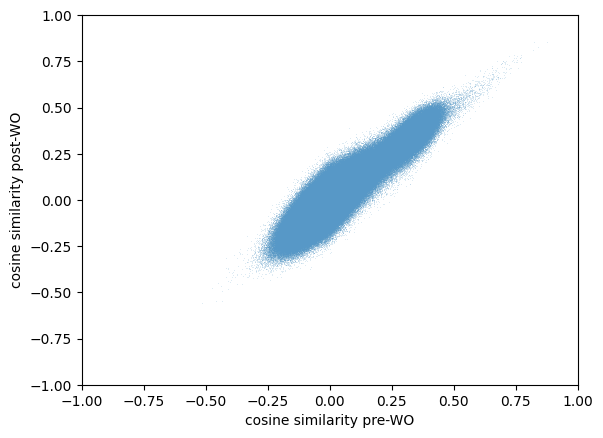

In [142]:
cosine_sims_pre_wo, cosine_sims_post_wo = InterferenceChanges(
    W_dec[:,torch.randperm(W_dec.shape[1])],
    W_O_concat[:,torch.randperm(W_O_concat.shape[1])])

sns.scatterplot(x=cosine_sims_pre_wo[::100],
                y=cosine_sims_post_wo[::100], s=.1)
plt.xlabel('cosine similarity pre-WO')
plt.ylabel('cosine similarity post-WO')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [99]:
# Scramble a tensor columns
W_O_concat_scrambled = W_O_concat[t.randperm(W_O_concat.shape[0]),:]

# Scramble a tensors columns
W_dec_scrambled = W_dec[:,t.randperm(W_dec.shape[1])]

In [100]:
W_O_concat_scrambled.shape

torch.Size([512, 512])

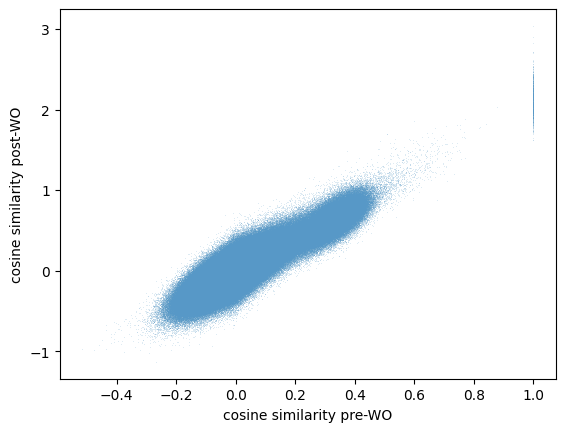

[[1.         0.88163324]
 [0.88163324 1.        ]]


In [101]:
W_dec_residual = W_dec_scrambled @ W_O_concat_scrambled
cosine_sims_W_dec = (W_dec_scrambled @ W_dec_scrambled.T).flatten()
cosine_sims_W_dec_residual = (W_dec_residual @ W_dec_residual.T).flatten()


sns.scatterplot(x=cosine_sims_W_dec.cpu().detach().numpy()[::100],
                y=cosine_sims_W_dec_residual.cpu().detach().numpy()[::100], s=.1)
plt.xlabel('cosine similarity pre-WO')
plt.ylabel('cosine similarity post-WO')
plt.xlim()
plt.show()

print(np.corrcoef(cosine_sims_W_dec.cpu().detach().numpy(), cosine_sims_W_dec_residual.cpu().detach().numpy()))

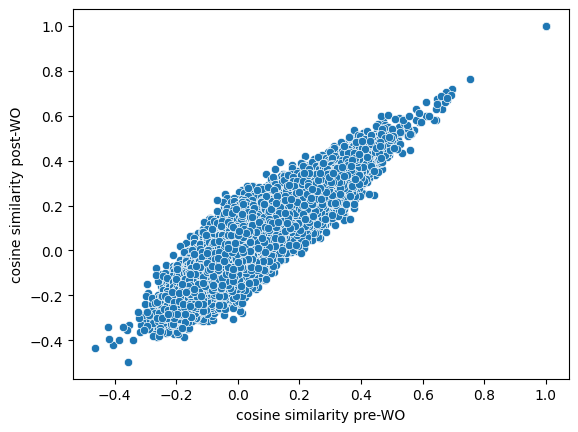

[[1.         0.89245016]
 [0.89245016 1.        ]]


In [44]:
W_dec_residual = W_dec_scrambled @ W_O_concat
W_dec_residual = W_dec_residual/W_dec_residual.norm(dim=1, keepdim=True)
cosine_sims_W_dec = (W_dec_scrambled @ W_dec_scrambled.T).flatten()
cosine_sims_W_O = (W_dec_residual @ W_dec_residual.T).flatten()

sns.scatterplot(x=cosine_sims_W_dec.cpu().detach().numpy()[::1313], y=cosine_sims_W_O.cpu().detach().numpy()[::1313])
plt.xlabel('cosine similarity pre-WO')
plt.ylabel('cosine similarity post-WO')
plt.show()

print(np.corrcoef(cosine_sims_W_dec.cpu().detach().numpy(), cosine_sims_W_O.cpu().detach().numpy()))

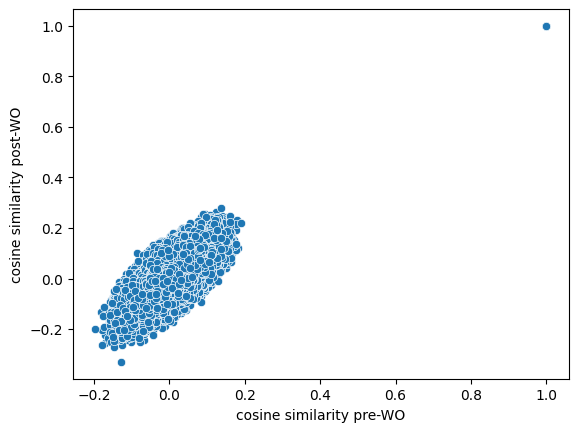

[[1.         0.71411736]
 [0.71411736 1.        ]]


In [25]:
# Generate random numbers in a normal distribution in pytorch

W_O_concat = torch.randn(size=W_O_concat.shape).to(device)

W_dec_residual = W_dec @ W_O_concat
W_dec_residual = W_dec_residual/W_dec_residual.norm(dim=1, keepdim=True)


cosine_sims_W_dec = (W_dec @ W_dec.T).flatten()
cosine_sims_W_O = (W_dec_residual @ W_dec_residual.T).flatten()


sns.scatterplot(x=cosine_sims_W_dec.cpu().detach().numpy()[::1313], y=cosine_sims_W_O.cpu().detach().numpy()[::1313])
plt.xlabel('cosine similarity pre-WO')
plt.ylabel('cosine similarity post-WO')
plt.show()

print(np.corrcoef(cosine_sims_W_dec.cpu().detach().numpy(), cosine_sims_W_O.cpu().detach().numpy()))